In [1]:
from glob import glob
import numpy as np
from astropy.table import QTable, vstack
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.interpolate import interp1d

plt.style.use('paper')

In [2]:
def custom_sort(arr):
    def key_func(item):
        # Extract number from string and convert to integer
        num = int(item[4:])  # 'conf' has length 4
        # Return a tuple with two items:
        # First item is a boolean indicating if number is 10 (True for 'conf10' and False otherwise)
        # Second item is the number itself
        # This will sort 'conf10' last and others based on their numbers
        return (num == 10, num)
    
    return sorted(arr, key=key_func)

In [3]:
which = 'gaussians'
version = '_gaussians_v4'
# version = '_v2'

# which_time = ''
# which_time = '_6totaltime'
# which_time = '_6totaltime_flagged'
# which_time = '_60totaltime'
# which_time = '_60totaltime_flagged'

# which_time = '_6totaltime_noise'
# which_time = '_6totaltime_flagged_noise'
which_time = '_60totaltime_noise'
# which_time = '_60totaltime_flagged_noise'

if 'noise' in which_time:
    # model scaling factor
    model_f = 15000
    if '60' in which_time:
        model_f = model_f*np.sqrt(10)
else: 
    model_f  = 1

table = vstack([QTable.read(file) for file in glob(f'../data/tables{version}/table_fit_{which}{which_time}_conf*.fits')])
conf_unique = np.unique(table['conf']) 
conf_unique =  custom_sort(conf_unique)
conf_unique_ = np.unique(table['conf_']) 

min_baseline =  [8.7, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 64.0, 110.4, 367.6, 244.0,]
mrs_size =      [66.7, 28.5, 22.6, 16.2, 11.2, 6.7, 4.11, 2.58, 1.42, 0.814, 0.496]
beam_size =     [12.5, 3.38, 2.3, 1.42, 0.918, 0.545, 0.306, 0.211, 0.096, 0.057, 0.042]
configuration = ['conf0', 'conf1', 'conf2', 'conf3', 'conf4', 'conf5', 'conf6', 'conf7', 'conf8', 'conf9', 'conf10']
mrs_conf = np.arange(0,11)

print(conf_unique)

table.sort('conf')
table[table['conf']=='conf8']

['conf0', 'conf1', 'conf2', 'conf3', 'conf4', 'conf5', 'conf6', 'conf7', 'conf8', 'conf9', 'conf10']


conf,wide,sum_sim,sum_obs,rms_obs,max_sim,max_obs,sum_fit_sim,sum_fit_obs,errl_fit_sim,errh_fit_sim,errl_fit_obs,errh_fit_obs,sum_mask10_sim,sum_mask10_obs,sum_mask50_sim,sum_mask50_obs,rchi2_sim,rchi2_obs,conf_,wide_
,,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,
bytes6,bytes8,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64
conf8,4.9mrs0,144609.0625,0.6386063098907471,5.610579580217799e-07,1.0,1.6121215594466776e-05,144609.0625,0.5060511231422424,144609.0625,144609.0625,0.45184603333473206,0.5644267201423645,130148.0234375,0.3394070267677307,72307.3671875,0.42006897926330566,5.565755772937993e-16,0.6820301977765186,8.0,4.9
conf8,3.8mrs0,85567.5390625,0.5740445852279663,4.602975692068608e-07,1.0,2.4412782295257784e-05,85567.5390625,0.5929746031761169,85567.5390625,85567.5390625,0.5523339509963989,0.635560929775238,77009.421875,0.5188158750534058,42796.81640625,0.4411410689353943,5.600191380319245e-16,0.39638061260490215,8.0,3.8
conf8,0.4mrs0,855.6751098632812,0.023406578227877617,3.7727714750023916e-07,1.0,3.970316902268678e-05,855.6751098632812,0.023706931620836258,855.6751098632812,855.6751098632812,0.022617775946855545,0.024830499663949013,769.955322265625,0.019042056053876877,427.8323974609375,0.009458811953663826,5.231448090165855e-16,0.027620488414100596,8.0,0.4
conf8,0.8mrs0,3422.70068359375,0.0828000158071518,3.977454716245846e-07,1.0,4.4413965952116996e-05,3422.70068359375,0.08574919402599335,3422.70068359375,3422.70068359375,0.08124017715454102,0.09042201936244965,3079.2109375,0.07690154016017914,1713.6484375,0.04056766629219055,5.674881172136044e-16,0.07020338963546015,8.0,0.8
conf8,1.1mrs0,7701.07666015625,0.14723661541938782,2.939745691466253e-07,1.0,4.065423854626715e-05,7701.07666015625,0.1518026441335678,7701.07666015625,7701.07666015625,0.14671145379543304,0.1570102870464325,6929.81591796875,0.14115910232067108,3854.02294921875,0.07948732376098633,5.391302311304973e-16,0.0439931391587505,8.0,1.1
conf8,1.5mrs0,13690.8017578125,0.23246292769908905,3.1231732162458013e-07,1.0,3.933953121304512e-05,13690.8017578125,0.24042171239852905,13690.8017578125,13690.8017578125,0.23197074234485626,0.24907544255256653,12321.3916015625,0.22877025604248047,6833.02880859375,0.13367542624473572,5.7550398714149e-16,0.06333345734753883,8.0,1.5
conf8,1.9mrs0,21391.875,0.3209586441516876,3.3482601417843764e-07,1.0,3.7299905670806766e-05,21391.875,0.3317851424217224,21391.875,21391.875,0.31887349486351013,0.34504076838493347,19253.1171875,0.3193471133708954,10698.5908203125,0.19380882382392883,5.494069704162179e-16,0.09421075413849511,8.0,1.9
conf8,4.5mrs0,123217.2421875,0.6800305843353271,5.251263034862245e-07,1.0,1.877344948297832e-05,123217.2421875,0.5479001402854919,123217.2421875,123217.2421875,0.4973905682563782,0.601719319820404,110894.1875,0.41281837224960327,61605.26953125,0.44254663586616516,5.596539706908958e-16,0.5921528083459116,8.0,4.5


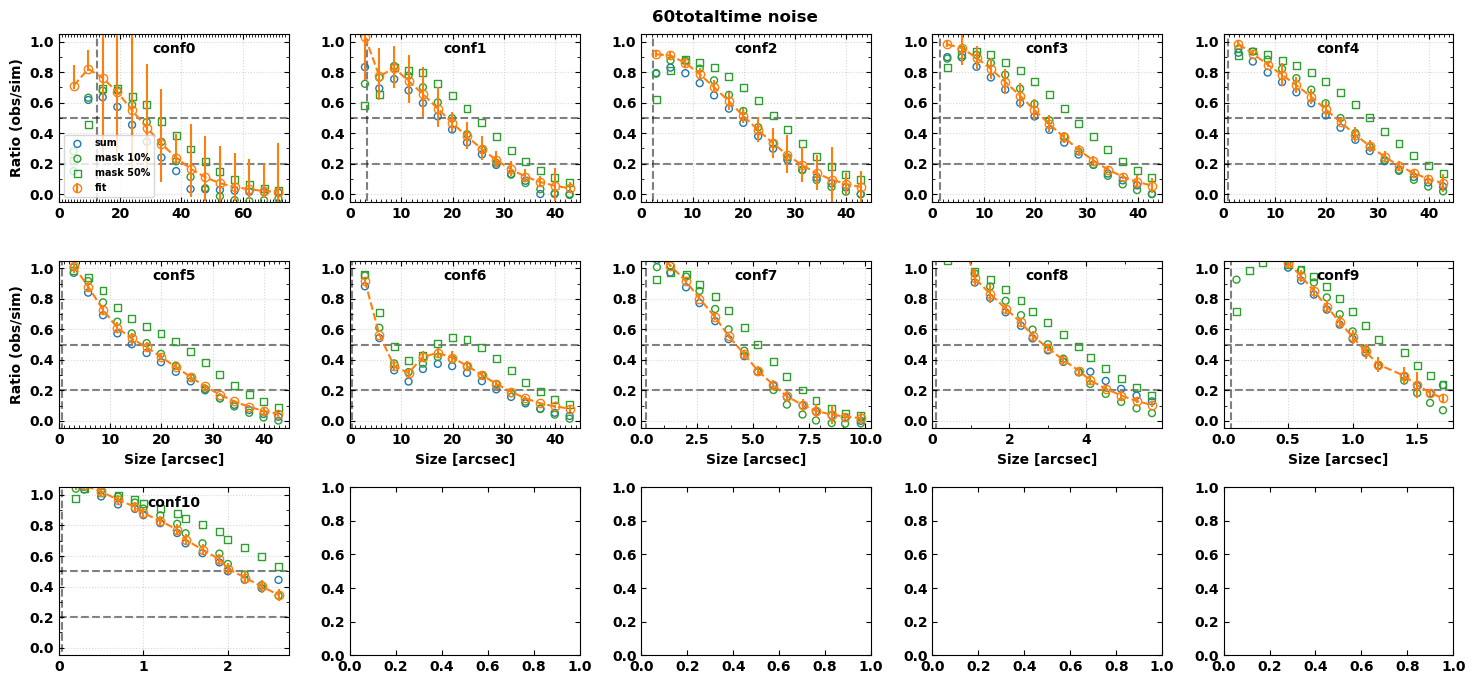

In [4]:
# Make scatter plot
fig1, ax1 = plt.subplots(3, 5, figsize=(15, 7))
ax1 = ax1.flatten()

colors = cm.turbo(np.linspace(0, 1, len(ax1)))

for i, conf in enumerate(conf_unique):

	if model_f!=1:  
		if conf == 'conf0':
			model_f_ = model_f/15
		else: 
			model_f_ = model_f
	else: 
		model_f_ = 1
		
	conf_tab = table[np.where(table['conf']==conf)]
	conf_arr = conf_tab['conf']
	wide_arr = [''] * len(conf_arr)

	sum_sim = conf_tab['sum_sim'].value/model_f_
	sum_obs = conf_tab['sum_obs'].value
	sum_fit_sim = conf_tab['sum_fit_sim'].value/model_f_
	sum_fit_obs = conf_tab['sum_fit_obs'].value
	errl_fit_sim = conf_tab['errl_fit_sim'].value/model_f_ 
	errh_fit_sim = conf_tab['errh_fit_sim'].value/model_f_
	errl_fit_obs = conf_tab['errl_fit_obs'].value 
	errh_fit_obs = conf_tab['errh_fit_obs'].value 
	sum_mask10_obs = conf_tab['sum_mask10_obs'].value
	sum_mask10_sim = conf_tab['sum_mask10_sim'].value/model_f_
	sum_mask50_obs = conf_tab['sum_mask50_obs'].value
	sum_mask50_sim = conf_tab['sum_mask50_sim'].value/model_f_
	ratio_arr = sum_obs/sum_sim
	ratio_fit_arr = sum_fit_obs/sum_fit_sim
	ratio_mask10_arr = sum_mask10_obs/sum_mask10_sim
	ratio_mask50_arr = sum_mask50_obs/sum_mask50_sim
	ratio_fiterrl_arr = errl_fit_obs/errl_fit_sim
	ratio_fiterrh_arr = errh_fit_obs/errh_fit_sim
	ferrh = np.abs(np.abs(errh_fit_obs-sum_fit_obs)/sum_fit_obs)
	ferrl = np.abs(np.abs(errl_fit_obs-sum_fit_obs)/sum_fit_obs)
	# ferrl[ferrl>10] = 100
	# ferrh[ferrh>10] = 100
	ratio_fiterrl_arr = np.abs(ratio_fit_arr*ferrl)
	ratio_fiterrh_arr = np.abs(ratio_fit_arr*ferrh)
	
	for j, wide in enumerate(conf_tab['wide']):
		wide_arr[j] = float(wide.replace('mrs0',''))
	wide_arr = np.array(wide_arr)

	ids = np.argsort(wide_arr)
	wide_arr = wide_arr[ids]
	ratio_fit_arr = ratio_fit_arr[ids]
	ratio_arr = ratio_arr[ids]
	ratio_mask10_arr = ratio_mask10_arr[ids]
	ratio_mask50_arr = ratio_mask50_arr[ids]

	#rati_arr
	ax1[i].scatter(wide_arr, ratio_arr, s=25, ec='C0', fc='none', label='sum')
	ax1[i].scatter(wide_arr, ratio_mask10_arr, s=25, ec='C2', fc='none', marker = 'o', label='mask 10%')
	ax1[i].scatter(wide_arr, ratio_mask50_arr, s=25, ec='C2', fc='none', marker = 's', label='mask 50%')

	ax1[i].errorbar(wide_arr, ratio_fit_arr, yerr=(ratio_fiterrl_arr, ratio_fiterrh_arr), color='C1', label='fit', fmt='o', markerfacecolor='none')	
	ax1[i].plot(wide_arr, ratio_fit_arr, ls='--', c='C1')

	ax1[i].text(0.5, 0.95, conf, transform=ax1[i].transAxes, weight='extra bold', fontsize=10, va='top', ha='center')
	ax1[i].set_ylim([-0.05, 1.05])
	
	xlim = ax1[i].get_xlim()
	ax1[i].hlines(0.2, 0, xlim[1], colors='k', ls='--', zorder=0, alpha=0.5)
	ax1[i].hlines(0.5, 0, xlim[1], colors='k', ls='--', zorder=0, alpha=0.5)
	ax1[i].vlines(beam_size[i], -2, 2,  colors='k', ls='--', zorder=0, alpha=0.5)

	ax1[i].set_xlim([0, xlim[1]])

	# ax1[i].xaxis.set_major_locator(MultipleLocator(10))
	ax1[i].xaxis.set_minor_locator(MultipleLocator(1))
	ax1[i].yaxis.set_minor_locator(MultipleLocator(0.1))
	ax1[i].grid(True, ls=':', alpha=0.5)

for i in [5,6,7,8,9]:
	ax1[i].set_xlabel('Size [arcsec]')

for i in [0,5]:
	ax1[i].set_ylabel('Ratio (obs/sim)')

ax1[0].legend(loc='lower left', fontsize=7)
	
fig1.suptitle(which_time.replace('_', ' ')[1:], fontweight='bold', y=0.97)

fig1.tight_layout()
# fig1.savefig(f'./../figs/scatter_ratio_{which}{which_time}.pdf', dpi=300, bbox_inches='tight', transparent=False)
fig1.savefig(f'./../figs/scatter_ratio_{which}{which_time}.png', dpi=300, bbox_inches='tight', transparent=False)